# Toy Problem

This notebook compares results from grid search, random search, and Bayesian search for a 1D problem on the first patient.

## Clinical Goals (Approved Plan)

idx | Name | Description | Type | GoalCriteria | AcceptanceLevel | ParameterValue
-|-|-|-|-|-|-
19 | PTV | At least 95 % volume at 4800 cGy dose | VolumeAtDose | AtLeast | 0.95 | 4800
20 | PTV | At least 99 % volume at 4320 cGy dose | VolumeAtDose | AtLeast | 0.99 | 4320
11 | SpinalCanal |  At most 2080 cGy dose at 0.35 cm$^3$ volume | DoseAtAbsoluteVolume| AtMost | 2080 | 0.35
9 | Lungs | At most 10 % volume at 2000 cGy dose | VolumeAtDose | AtMost | 0.1 | 2000
3 | Heart | At most 15 cm$^3$ volume at 2800 cGy dose | AbsoluteVolumeAtDose | AtMost | 15 | 2800
18 | Chestwall_L | At most 30 cm$^3$ volume at 3000 cGy dose | AbsoluteVolumeAtDose | AtMost | 30 | 3000
14 | Rib | At most 1 cm$^3$ volume at 3200 cGy dose | AbsoluteVolumeAtDose | AtMost | 1 | 3200

## Clinical Goals (Implemented)

idx | Roi | Type | Goal Criteria | AcceptanceLevel | Parameter Value
-|-|-|-|-|-|
0 | PTV | MinDvh | AtLeast | 4800 | 95
1 | PTV | MaxDose | AtMost | 6240 | 0
2 | SpinalCanal | MaxDvh | AtMost | 2080 | 0.67
3 | Lungs | MaxDvh | AtMost | 2000 | 10
4 | Heart | MaxDvh | AtMost | 2800 |  1.84
5 | ChestWall_L | MaxDvh | AtMost | 3000 | 2.04
6 | Rib | MaxDvh | AtMost | 3200 | 0.27

## Objective Terms

idx | Name | Description | FunctionType | DoseValue | PercentVolume | Weight
-|-|-|-|-|-|-
0 | PTV | Min DVH 4800 cGy to 95% volume | MinDvh | 4800 | 95 | 1
1 | PTV | Max Dose 6240 cGy | MaxDose | 6240 | 0 | 1
2 | SpinalCanal | Max DVH 2080 cGy to 0.67% volume | MaxDvh | 2080 | 0.67 | 1
3 | Lungs | Max DVH 2000 cGy to 10% volume | MaxDvh | 2000 | 10 | 1
4 | Heart | Max DVH 2800 cGy to 2% volume | MaxDvh | 2800 | 1.84 | 1
5 | Chestwall_L | Max DVH 3000 cGy to 2.04% volume | MaxDvh | 3000 | 2.04 | 1
6 | Rib | Max DVH 3200 cGy to 0.27% volume | MaxDvh | 3200 | 0.27 | 1

In [1]:
from importlib import reload
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.ensemble as ens
import sklearn.gaussian_process as gp

sys.path.append('../../src')
import plots

In [286]:
def normalize_plans(results):
    # Print success
    flag_0 = len(results[results['Flag'] == 0])
    flag_1 = len(results[results['Flag'] == 1])
    flag_2 = len(results[results['Flag'] == 2])
    print(f'Success: {flag_0}, Not Normalized: {flag_1}, Fail: {flag_2}')
    
    # Normalize plans
    if flag_1 > 0:
        for _, row in results.iterrows():
            scale = 4800/row[0]
            for ii in range(7):
                row[ii] *= scale

In [290]:
# Problem
funcs = pd.read_csv('funcs.csv')
funcs_toy = pd.read_csv('funcs_toy.csv')
goals = pd.read_csv('goals.csv')

# Approved plan
results_approved = pd.read_pickle('results_approved.npy')
dvh_approved = np.load('dvh_approved.npy', allow_pickle=True)

# Random samples
pars_sample = pd.read_pickle('pars_sample.npy')
results_sample = pd.read_pickle('results_sample.npy')
normalize_plans(results_sample)

# Grid search
pars_grid = pd.read_pickle('pars_grid.npy')
results_grid = pd.read_pickle('results_grid.npy')
normalize_plans(results_grid)
            
# Random search
x_rand = np.load('x_iters_rand.npy').squeeze()
fun_rand = np.load('func_vals_rand.npy')

# Bayesian search
x_bayes = np.load('x_iters_bayes.npy').squeeze()
fun_bayes = np.load('func_vals_bayes.npy')

Success: 100, Not Normalized: 1, Fail: 0
Success: 24, Not Normalized: 1, Fail: 0


# Random Samples

Results from 100 random samples of DoseValue parameters (except for PTV MinDvh), with 25-100% of parameter ranges.

(<Figure size 432x288 with 2 Axes>, None)

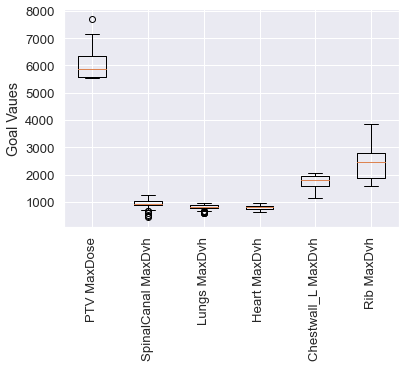

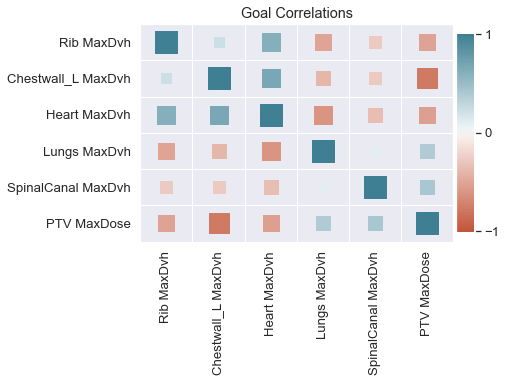

<Figure size 432x288 with 0 Axes>

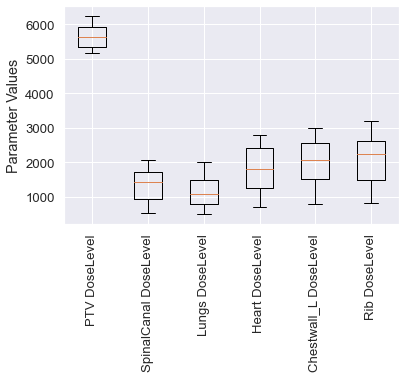

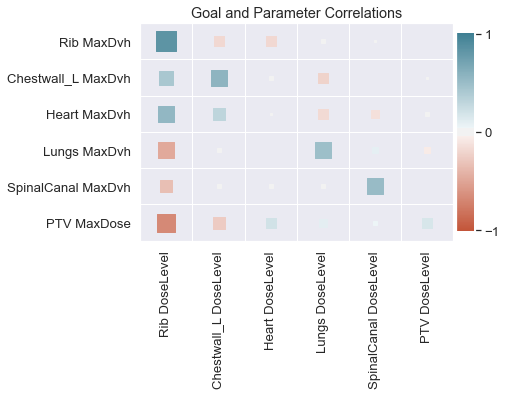

In [291]:
plots.boxplot(goals[1:], results_sample, 'goals')
plt.figure(), plots.corrplot(goals[1:], results_sample, title='Goal Correlations')
plt.figure(), plots.boxplot(funcs_sample, pars_sample, 'pars')
plt.figure(), plots.corrplot(goals[1:], results_sample, funcs_sample, pars_sample, 'Goal and Parameter Correlations')

In [292]:
def linear_penalty(funcs, pars, goals, results):
    func_vals = 0
    x_grid, _ = plots.format_data(funcs, pars, 'pars')
    x_grid = x_grid[0].values
    ydata, _ = plots.format_data(goals[1:], results, 'goals')
    for ii in range(len(ydata)):
        level = goals.iloc[ii+1]['AcceptanceLevel']
        func_vals += (ydata[ii] - level)/level
    return func_vals

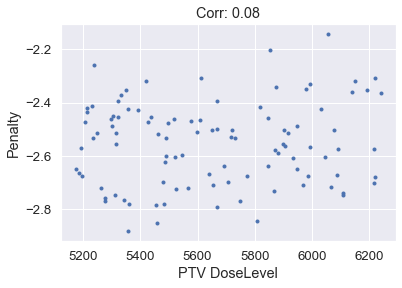

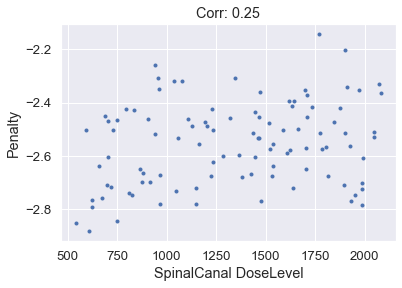

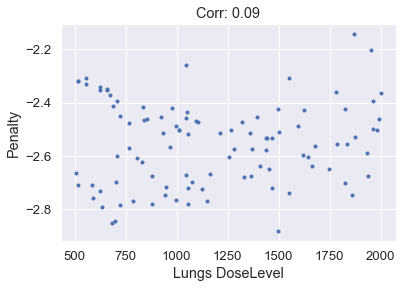

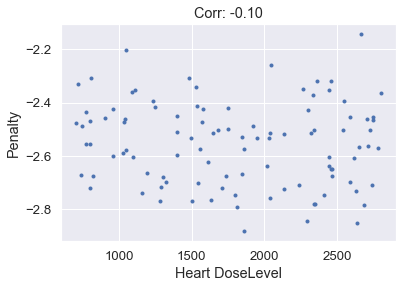

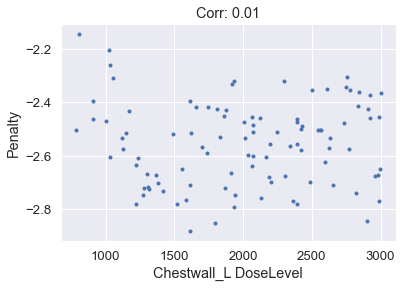

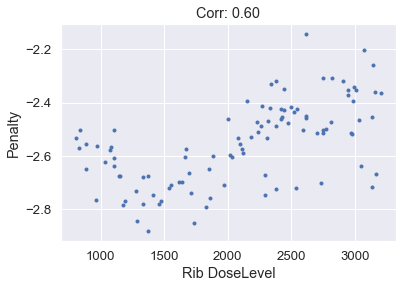

In [294]:
fun_sample = linear_penalty(funcs_sample, pars_sample, goals, results_sample)
for term in range(1, 7):
    par_vals = pars_sample[pars_sample['Term'] == term]
    par_vals = par_vals
    roi = par_vals['Roi'].values[0]
    dose = par_vals['DoseLevel']
    corr = np.corrcoef(dose, fun_sample)[0, 1]
    plt.figure()
    plt.plot(dose, fun_sample, '.')
    plt.xlabel(f'{roi} DoseLevel')
    plt.ylabel('Penalty')
    plt.title(f'Corr: {corr:.2f}')

# Grid Search

Based on the results above, the rib parameter had the highest correlation with the clinical goals and penalty.
Now we do a grid search over 25-100% of the rib DoseLevel parameter range.

(<Figure size 432x288 with 2 Axes>, None)

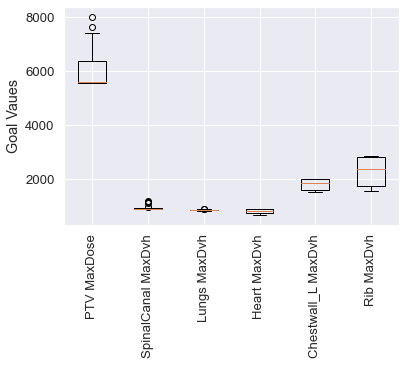

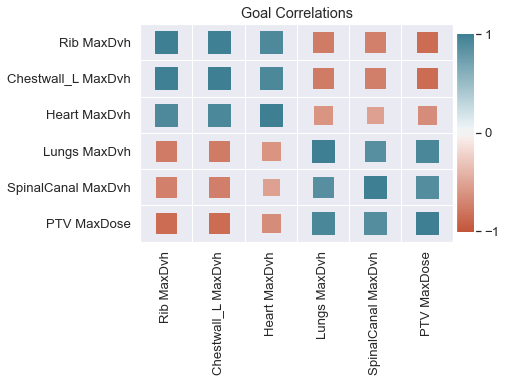

<Figure size 432x288 with 0 Axes>

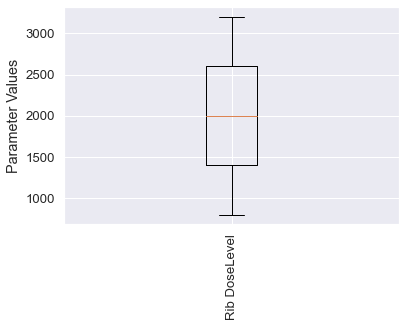

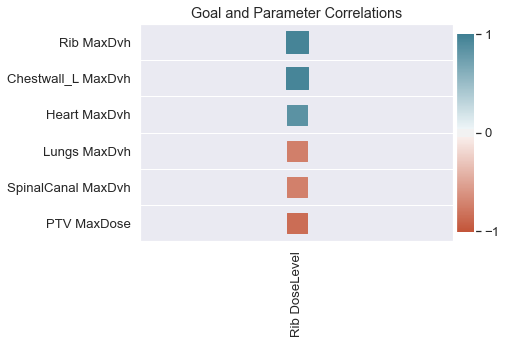

In [78]:
plots.boxplot(goals[1:], results_grid, 'goals')
plt.figure(), plots.corrplot(goals[1:], results_grid, title='Goal Correlations')
plt.figure(), plots.boxplot(funcs, pars_grid, 'pars')
plt.figure(), plots.corrplot(goals[1:], results_grid, funcs, pars_grid, 'Goal and Parameter Correlations')

Text(0.5, 1.0, 'Corr: 0.65')

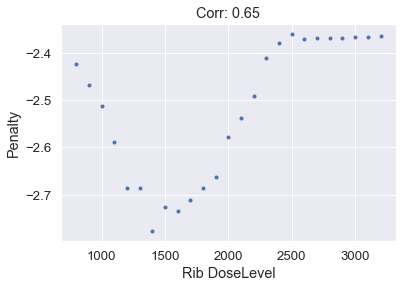

In [225]:
fun_grid = linear_penalty(funcs, pars_grid, goals, results_grid)
par_vals = pars_grid[pars_grid['Term'] == 6]
par_vals = par_vals
dose = par_vals['DoseLevel']
corr = np.corrcoef(dose, fun_grid)[0, 1]
plt.plot(dose, fun_grid, '.')
plt.xlabel('Rib DoseLevel')
plt.ylabel('Penalty')
plt.title(f'Corr: {corr:.2f}')

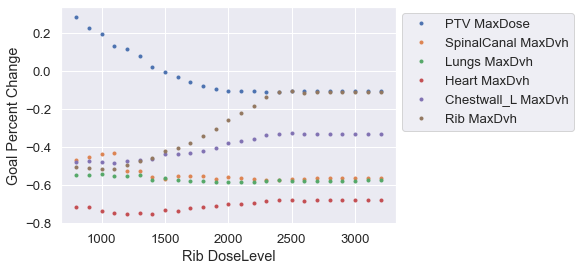

In [231]:
labels = []
for ii in range(1, 7):
    roi = goals.iloc[ii]['Roi']
    goal = goals.iloc[ii]['Type']
    result = (results_grid[ii] - goals.iloc[ii]['AcceptanceLevel'])/goals.iloc[ii]['AcceptanceLevel']
    plt.plot(dose, result, '.')
    labels.append(f'{roi} {goal}')
plt.xlabel('Rib DoseLevel')
plt.ylabel('Goal Percent Change')
plt.legend(labels, bbox_to_anchor=(1, 1));

# Compare Search Methods

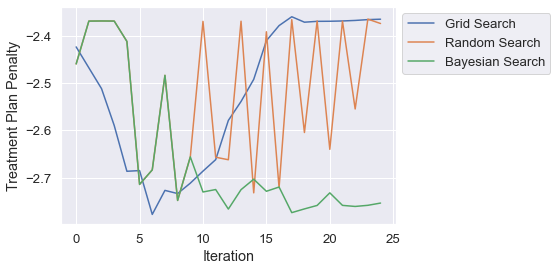

In [169]:
# Compare convergence of optimization methods
plt.plot(fun_grid)
plt.plot(fun_rand)
plt.plot(fun_bayes)
plt.xlabel('Iteration')
plt.ylabel('Treatment Plan Penalty')
plt.legend(['Grid Search', 'Random Search', 'Bayesian Search'],
           bbox_to_anchor=(1, 1));

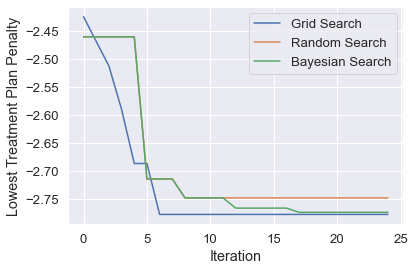

In [170]:
# Compare convergence of optimization methods
plt.plot(np.minimum.accumulate(fun_grid))
plt.plot(np.minimum.accumulate(fun_rand))
plt.plot(np.minimum.accumulate(fun_bayes))
plt.xlabel('Iteration')
plt.ylabel('Lowest Treatment Plan Penalty')
plt.legend(['Grid Search', 'Random Search', 'Bayesian Search'],
           bbox_to_anchor=(1, 1));

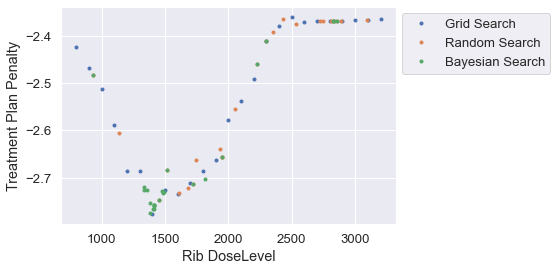

In [171]:
# Compare penalty value results
plt.plot(x_grid, fun_grid, '.')
plt.plot(x_rand, fun_rand, '.')
plt.plot(x_gp, fun_bayes, '.')
plt.xlabel('Rib DoseLevel')
plt.ylabel('Treatment Plan Penalty')
plt.legend(['Grid Search', 'Random Search', 'Bayesian Search'],
           bbox_to_anchor=(1, 1));

In [316]:
# Compare optimal penalty values

def print_opt(x, fun, method):
    idx = np.argmin(fun)
    print(f'{method} Rib DoseLevel: {x[idx]}, Penalty Value: {fun[idx]:.2f}')
    
print(f'Default Parameters Penalty Value: {fun_sample[0]:.2f}')
print(f'Approved Plan Penalty Value: {linear_penalty(funcs, pars_sample, goals, results_approved)[0]:.2f}')
print_opt(x_grid, fun_grid, 'Grid Search')
print_opt(x_rand, fun_rand, 'Random Search')
print_opt(x_gp, fun_gp, 'Bayesian Search')

Default Parameters Penalty Value: -2.37
Approved Plan Penalty Value: -2.16
Grid Search Rib DoseLevel: 1400.0, Penalty Value: -2.78
Random Search Rib DoseLevel: 1454.3751069922719, Penalty Value: -2.75
Bayesian Search Rib DoseLevel: 1384.7830992256718, Penalty Value: -2.77


In [299]:
# Compare goal results
res_names = ['DF', 'GS', 'RS', 'BS']
opt_idx = [0, np.argmin(fun_grid)]
res_vals = [results_sample, results_grid]

# AHA: also need to get optimal results for all methods!

for goal, row in goals.iterrows():
    print(f"ROI: {row['Roi']}, Type: {row['Type']}")
    for ii in range(len(res_vals)):
        res = res_vals[ii][res_vals[ii]['Sample'] == opt_idx[ii]][goal][opt_idx[ii]]
        level = row['AcceptanceLevel']
        diff_goal = 100*(res - level)/level
        app = results_approved[goal][0]
        diff_app = 100*(res - app)/app
        print(f'{res_names[ii]} Value: {res:.2f}, % Diff Goal: {diff_goal:.2f}, % Diff App: {diff_app:.2f}')
    print()

ROI: PTV, Type: MinDvh
DF Value: 4800.00, % Diff Goal: 0.00, % Diff App: -0.00
GS Value: 4800.00, % Diff Goal: 0.00, % Diff App: -0.00

ROI: PTV, Type: MaxDose
DF Value: 5572.02, % Diff Goal: -10.70, % Diff App: -8.30
GS Value: 6371.04, % Diff Goal: 2.10, % Diff App: 4.85

ROI: SpinalCanal, Type: MaxDvh
DF Value: 906.26, % Diff Goal: -56.43, % Diff App: -13.22
GS Value: 922.23, % Diff Goal: -55.66, % Diff App: -11.69

ROI: Lungs, Type: MaxDvh
DF Value: 849.81, % Diff Goal: -57.51, % Diff App: 8.46
GS Value: 858.64, % Diff Goal: -57.07, % Diff App: 9.58

ROI: Heart, Type: MaxDvh
DF Value: 897.61, % Diff Goal: -67.94, % Diff App: 2.88
GS Value: 695.84, % Diff Goal: -75.15, % Diff App: -20.24

ROI: Chestwall_L, Type: MaxDvh
DF Value: 2013.65, % Diff Goal: -32.88, % Diff App: 7.55
GS Value: 1614.46, % Diff Goal: -46.18, % Diff App: -13.77

ROI: Rib, Type: MaxDvh
DF Value: 2846.11, % Diff Goal: -11.06, % Diff App: -13.82
GS Value: 1735.53, % Diff Goal: -45.76, % Diff App: -47.45



In [280]:
res_vals[ii][res_vals[ii]['Sample'] == opt_idx[ii]][goal][opt_idx[ii]]

4800.0

In [ ]:
# The results for the approved plan are sometimes different from what I used here
# (MaxDose vs. MaxDvh in some cases...)

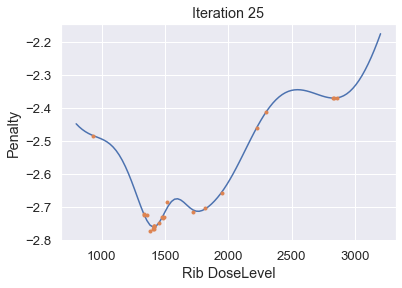

In [194]:
# Guassian Process

# Should save the surrogate models next time...
# It says the kernels are tuned, so can't assume it's what I've input

x_vals = np.linspace(800, 3200, 100)
for idx in [24]:#range(10, 25):
    plt.figure()  
    #plt.plot(x_grid, fun_grid, '.')
    #plt.plot(x_rand, fun_rand, '.')
    model = gp.GaussianProcessRegressor(kernel=1**2 * gp.kernels.Matern(length_scale=1, nu=2.5) + gp.kernels.WhiteKernel(noise_level=1),
                         n_restarts_optimizer=2, random_state=209652396)
    model.fit(x_gp[:idx].reshape(-1, 1), fun_gp[:idx] )   
    y_vals = model.predict(x_vals.reshape(-1, 1))
    plt.plot(x_vals, y_vals)
    plt.plot(x_gp[:idx], fun_gp[:idx], '.')
    #plt.plot(x_gp[idx], fun_gp[idx], '.')
    plt.xlabel('Rib DoseLevel')
    plt.ylabel('Penalty')
    plt.title(f'Iteration {idx+1}')
    
# Add standard deviation?